<a href="https://colab.research.google.com/github/walidbayoud/Stock_Price_Prediction_LSTM/blob/main/Stock_Price_Prediction_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Description:
This program uses an artificial recurrent neural network called Long Short Term Memory (LSTM) to predict the closing stock price of a corporation (MSFT) using the past days' stock price.


### Importring Data

In [14]:
#Import the libraries
import pandas as pd

#Get Data from the csv file
df = pd.read_csv('/content/sample_data/MSFT.csv')
#Display Data
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060163,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062311,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063386,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061774,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060700,47894400
...,...,...,...,...,...,...,...
9598,2024-04-15,426.600006,426.820007,413.429993,413.640015,413.640015,20273500
9599,2024-04-16,414.570007,418.399994,413.730011,414.579987,414.579987,16765600
9600,2024-04-17,417.250000,418.880005,410.329987,411.839996,411.839996,15855500
9601,2024-04-18,410.630005,411.890015,403.950012,404.269989,404.269989,21029900


## Processing Data

In [15]:
#Limit the columns to only Date and Close
df = df[['Date','Close']]
df

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9598,2024-04-15,413.640015
9599,2024-04-16,414.579987
9600,2024-04-17,411.839996
9601,2024-04-18,404.269989


In [16]:
#Turn the Date strings to datetime
df['Date'] = pd.to_datetime(df['Date'])
df['Date']

<ipython-input-16-1bb55c8e7ebd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


0      1986-03-13
1      1986-03-14
2      1986-03-17
3      1986-03-18
4      1986-03-19
          ...    
9598   2024-04-15
9599   2024-04-16
9600   2024-04-17
9601   2024-04-18
9602   2024-04-19
Name: Date, Length: 9603, dtype: datetime64[ns]

In [17]:
#Deleting the actula indexe and replace it by Date
df.index=df.pop('Date')
df

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090
...,...
2024-04-15,413.640015
2024-04-16,414.579987
2024-04-17,411.839996


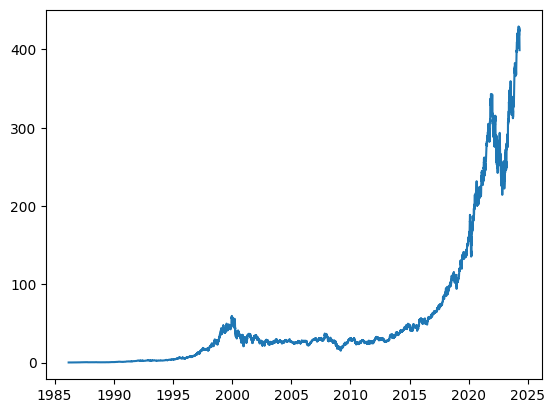

In [18]:
#visualizing the processed Data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.plot(df.index, df['Close'])

In [59]:
#Getting the Data ready to Train
import pandas as pd
import numpy as np


def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = pd.to_datetime(first_date_str)
    last_date = pd.to_datetime(last_date_str)

    target_date = first_date

    dates = []
    X, Y = [], []

    while True:
        df_subset = dataframe.loc[:target_date].tail(n + 1)

        if len(df_subset) != n + 1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_date = target_date + pd.Timedelta(days=1)  # Change to daily intervals

        if next_date > last_date:
            break

        target_date = next_date

    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates

    for i in range(n):
        ret_df[f'Target-{n - i}'] = [x[i] for x in X]

    ret_df['Target'] = Y

    return ret_df

# Test the function
windowed_df = df_to_windowed_df(df, '2022-11-01', '2023-11-01', n=3)
print(windowed_df)



    Target Date    Target-3    Target-2    Target-1      Target
0    2022-11-01  226.750000  235.869995  232.130005  228.169998
1    2022-11-02  235.869995  232.130005  228.169998  220.100006
2    2022-11-03  232.130005  228.169998  220.100006  214.250000
3    2022-11-04  228.169998  220.100006  214.250000  221.389999
4    2022-11-05  228.169998  220.100006  214.250000  221.389999
..          ...         ...         ...         ...         ...
361  2023-10-28  330.529999  340.670013  327.890015  329.809998
362  2023-10-29  330.529999  340.670013  327.890015  329.809998
363  2023-10-30  340.670013  327.890015  329.809998  337.309998
364  2023-10-31  327.890015  329.809998  337.309998  338.109985
365  2023-11-01  329.809998  337.309998  338.109985  346.070007

[366 rows x 5 columns]


In [60]:
#Reshape the Data

def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np= windowed_dataframe.to_numpy()

  dates =df_as_np[:,0]

  middle_matrix = df_as_np[:,1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y= df_as_np[:,-1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y=windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((366,), (366, 3, 1), (366,))

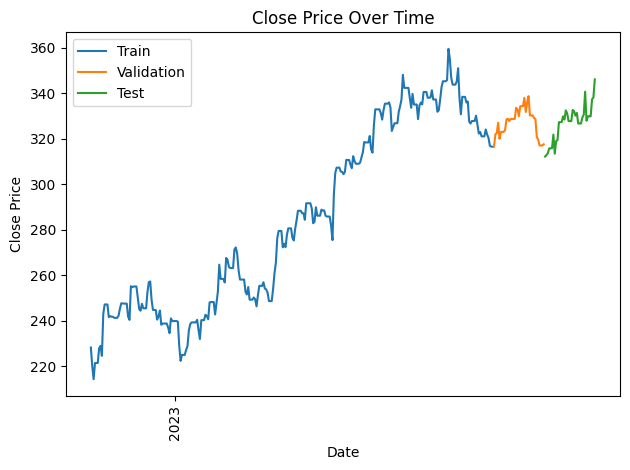

In [61]:
#Split the Data into training,validation, and testing Data

q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]

dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train,y_train)
plt.plot(dates_val,y_val)
plt.plot(dates_test,y_test)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Year-month format
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Show tick for every year

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price Over Time')

plt.legend(['Train', 'Validation', 'Test'])

plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlap

plt.show()


In [62]:
#Creating the Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3,1)),
                    layers.LSTM(64),
                    layers.Dense(32,activation='relu'),
                    layers.Dense(32,activation='relu'),
                    layers.Dense(1)])
model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])
model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=100)

Epoch 1/100
10/10 [==============================] - 4s 76ms/step - loss: 81787.4688 - mean_absolute_error: 283.1807 - val_loss: 106303.0156 - val_mean_absolute_error: 325.9830
Epoch 2/100
10/10 [==============================] - 0s 8ms/step - loss: 81468.0781 - mean_absolute_error: 282.6172 - val_loss: 105917.2891 - val_mean_absolute_error: 325.3908
Epoch 3/100
10/10 [==============================] - 0s 11ms/step - loss: 81043.2344 - mean_absolute_error: 281.8613 - val_loss: 105166.8281 - val_mean_absolute_error: 324.2355
Epoch 4/100
10/10 [==============================] - 0s 8ms/step - loss: 80155.1406 - mean_absolute_error: 280.2851 - val_loss: 103752.3594 - val_mean_absolute_error: 322.0469
Epoch 5/100
10/10 [==============================] - 0s 7ms/step - loss: 78587.2656 - mean_absolute_error: 277.4747 - val_loss: 101462.7891 - val_mean_absolute_error: 318.4724
Epoch 6/100
10/10 [==============================] - 0s 9ms/step - loss: 76527.6875 - mean_absolute_error: 273.7357 - 

10/10 [==============================] - 0s 2ms/step


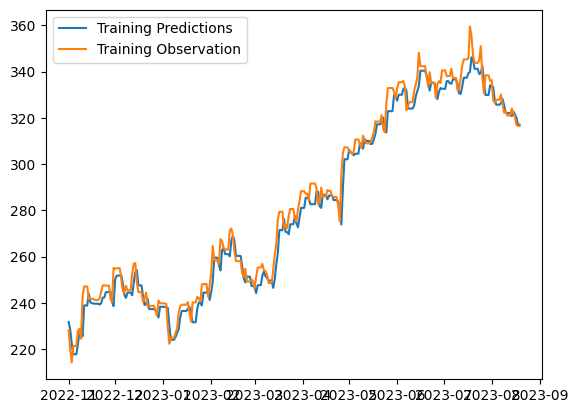

In [63]:
#training the Model
train_predictions = model.predict(X_train).flatten()
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observation'])

2/2 [==============================] - 0s 6ms/step


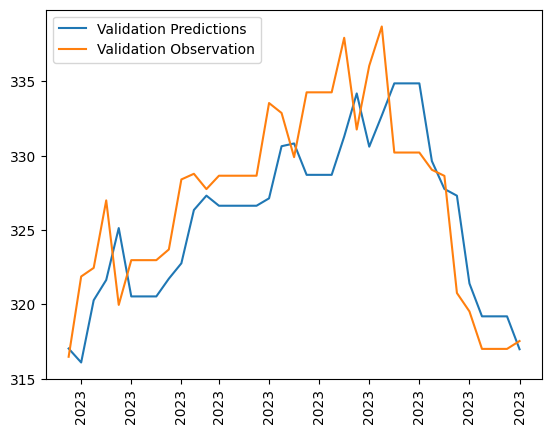

In [64]:
val_predictions = model.predict(X_val).flatten()

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Year-month format
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observation'])

2/2 [==============================] - 0s 7ms/step


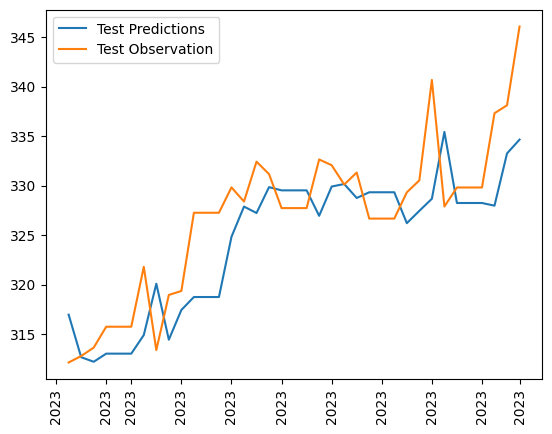

In [65]:
test_predictions = model.predict(X_test).flatten()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Year-month format
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Test Predictions', 'Test Observation'])

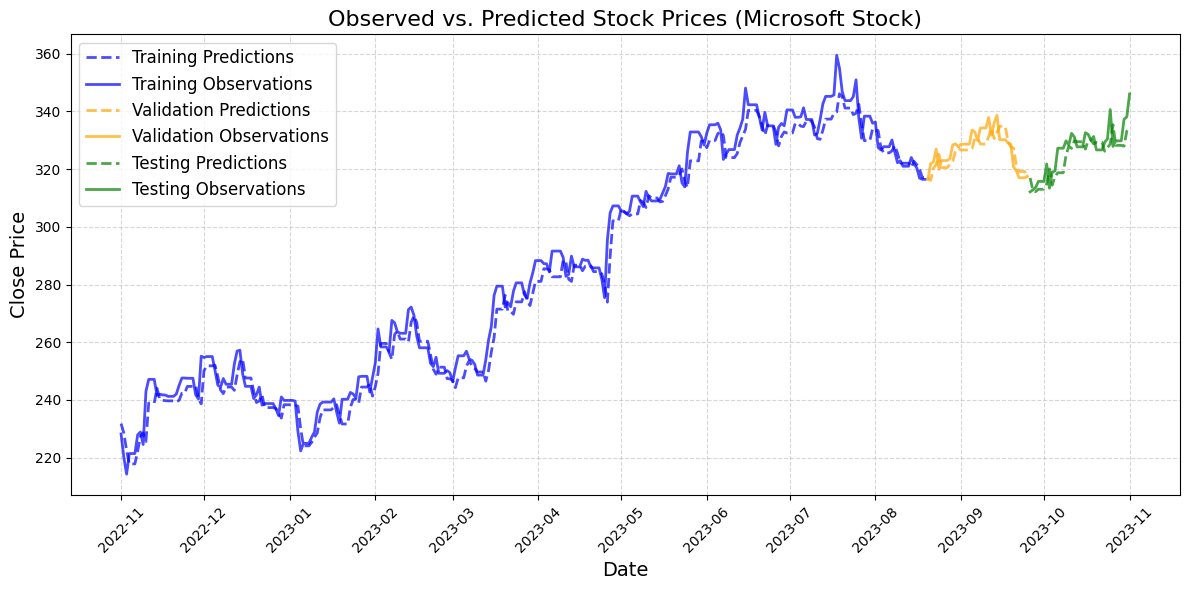

In [72]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(12, 6))


plt.plot(dates_train, train_predictions, linestyle='--', color='blue', linewidth=2, alpha=0.7)
plt.plot(dates_train, y_train, linestyle='-', color='blue', linewidth=2, alpha=0.7)

plt.plot(dates_val, val_predictions, linestyle='--', color='orange', linewidth=2, alpha=0.7)
plt.plot(dates_val, y_val, linestyle='-', color='orange', linewidth=2, alpha=0.7)

plt.plot(dates_test, test_predictions, linestyle='--', color='green', linewidth=2, alpha=0.7)
plt.plot(dates_test, y_test, linestyle='-', color='green', linewidth=2, alpha=0.7)

plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price', fontsize=14)
plt.title('Observed vs. Predicted Stock Prices (Microsoft Stock)', fontsize=16)

plt.grid(True, linestyle='--', alpha=0.5)

# Format dates on the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.legend(['Training Predictions', 'Training Observations',
            'Validation Predictions', 'Validation Observations',
            'Testing Predictions', 'Testing Observations'],
           loc='upper left', fontsize=12)

plt.tight_layout()  # Adjust layout to prevent overlap

plt.show()
